## Прогнозирование уровня средней заработной платы в России


In [14]:
!pip install -U statsmodels==0.8.0rc1

Requirement already up-to-date: statsmodels==0.8.0rc1 in c:\users\aleh\anaconda2\lib\site-packages


In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
from scipy.stats import boxcox
from itertools import product
import warnings
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\aleh\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
salary_data = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'],dayfirst=True)
salary_data.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


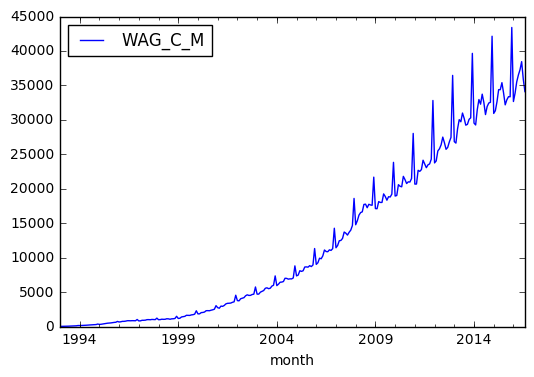

In [3]:
salary_data.plot()

Визуальный анализ: По графику видно, что ряд имеет тренд и сезонность. Также можно отметить, что дисперсия увеличивается с течением времени. Попробуем стабилизировать дисперсию. 

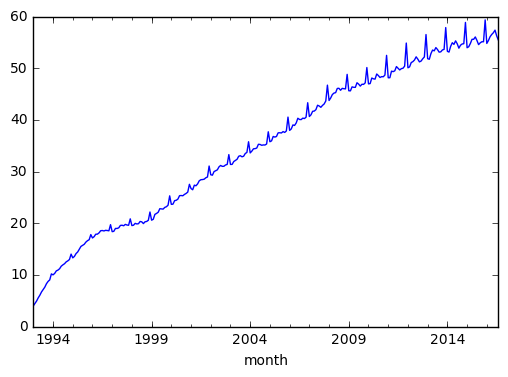

In [4]:
salary_data['wag_box'], lmbda = boxcox(salary_data['WAG_C_M'])
salary_data.wag_box.plot()

Теперь попробуем сделать ряд стационарным с помощью дифференцирования

p-value:  0.0143961521649
p-value:  0.0146971334948
p-value:  5.20360371582e-08


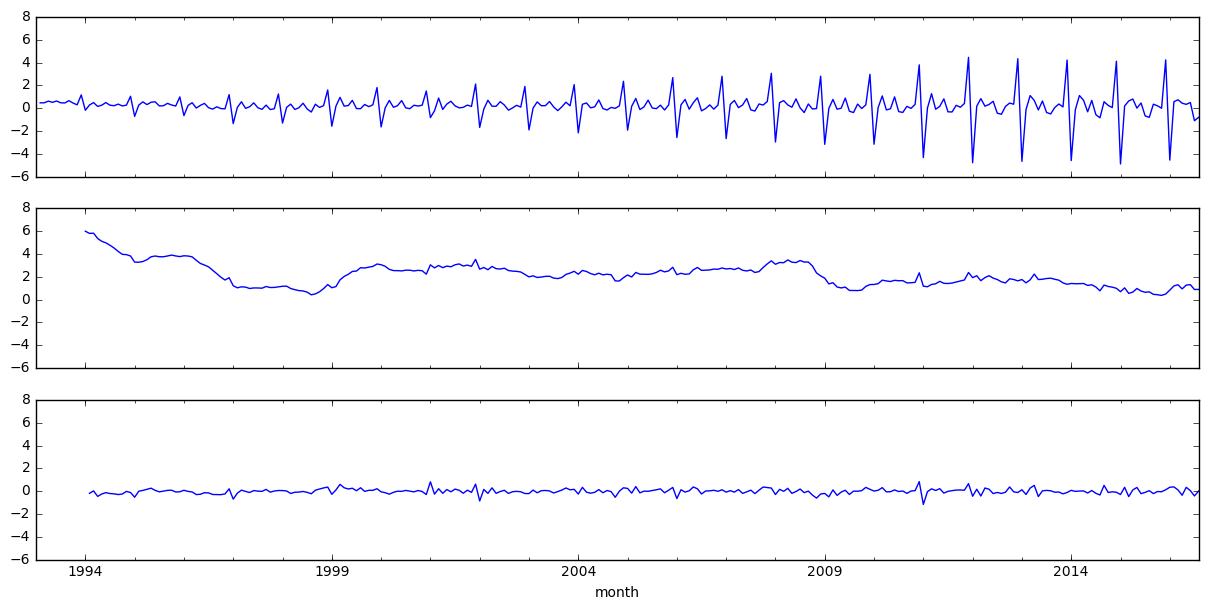

In [39]:
#обычное дифференцирование
salary_data['wag_diff1'] = salary_data['wag_box'] - salary_data['wag_box'].shift(1)
print 'p-value: ', sm.tsa.stattools.adfuller(salary_data['wag_diff1'][1:])[1]

f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
salary_data['wag_diff1'][1:].plot(ax=ax1)
# Сезонное дифференцирование
salary_data['wag_diff12'] = salary_data['wag_box']  - salary_data['wag_box'].shift(12)
print 'p-value: ', sm.tsa.stattools.adfuller(salary_data['wag_diff12'][12:])[1]

salary_data['wag_diff12'][12:].plot(ax=ax2)
# и сезонное, и обычное дифференцирование
salary_data['wag_diff13'] = salary_data['wag_diff12'][12:]-salary_data['wag_diff12'][12:].shift(1)
print 'p-value: ', sm.tsa.stattools.adfuller(salary_data['wag_diff13'][13:])[1]
salary_data['wag_diff13'].plot(ax=ax3)

plt.show()

Для 3 вариантов дифференцирования p-value меньше чем 0.05, но исходя из графиков 3 преобразование больше 
всего похоже на стационарное.

Подбираем Q,q, P,p параметры, c помощью автокорреляционной и частично-автокорреляционной функциию

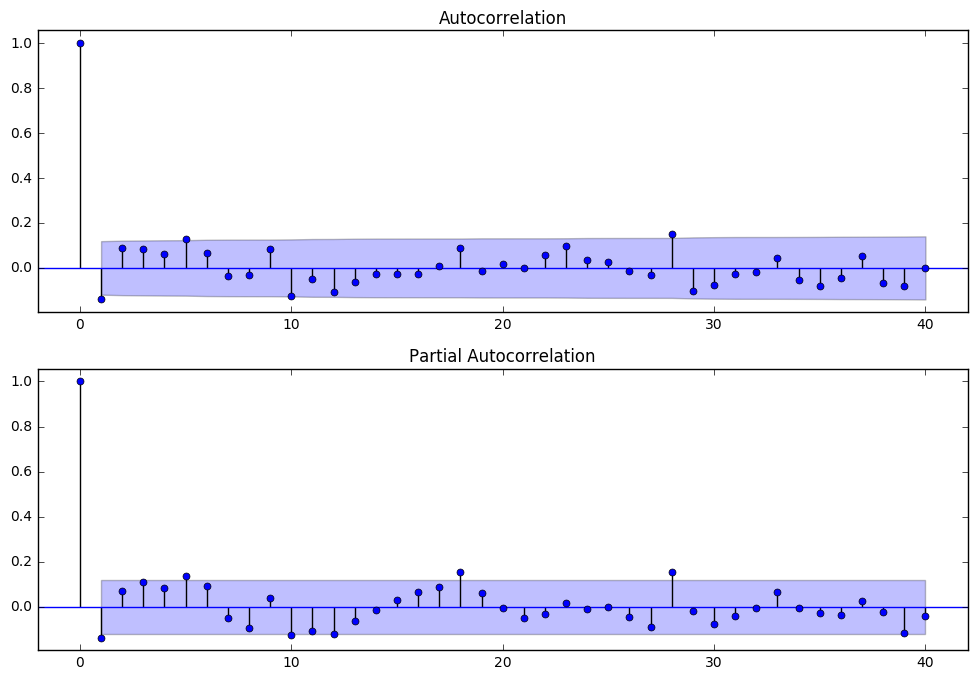

In [41]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(salary_data['wag_diff13'][13:].values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(salary_data['wag_diff13'][13:], lags=40, ax=ax2)

Исходя из графиков выберем следуюющие первоначальные параметры: Q=0, q=5, P=1, p=5

In [52]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [53]:
print ps

[0, 1, 2, 3, 4, 5]


In [54]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

TypeError: data type not understood

In [9]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(sal_box_diff13, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 2, 1, 0))
('wrong parameters:', (0, 2, 1, 1))


In [10]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
16  (1, 1, 1, 1)  26.171408
28  (2, 1, 1, 1)  26.748573
20  (1, 2, 1, 1)  28.462451
40  (3, 1, 1, 1)  28.664959
32  (2, 2, 1, 1)  28.711579


In [32]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            wag_box   No. Observations:                  271
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  -8.086
Date:                            Thu, 15 Dec 2016   AIC                             26.171
Time:                                    02:29:45   BIC                             44.182
Sample:                                02-01-1994   HQIC                            33.403
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2110      0.062     -3.427      0.001      -0.332      -0.090
ma.L1         -0.9044      0.035   

Критерий Стьюдента: p = 0.159653794047
Критерий Дики-Фуллера: p = 9.672156485e-30


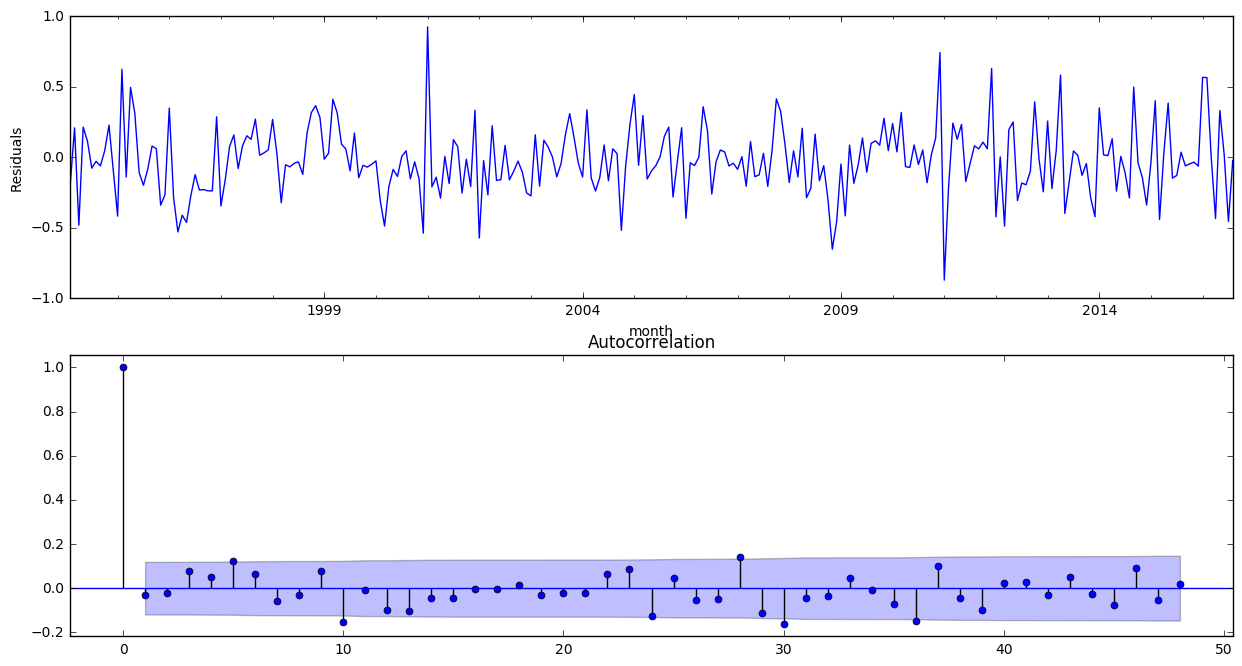

In [30]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid.plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=48, ax=ax)

print "Критерий Стьюдента:", "p =",stats.ttest_1samp(best_model.resid, 0)[1]
print "Критерий Дики-Фуллера:", "p =" , sm.tsa.stattools.adfuller(best_model.resid)[1]

Исходя из критерия Стьюдента, остатки несмещенные. Критерий Дики-Фулера говорит нам, что ряд стационарный. Но остатки автокоррелированы(по критерию Льюнга-Бокса).

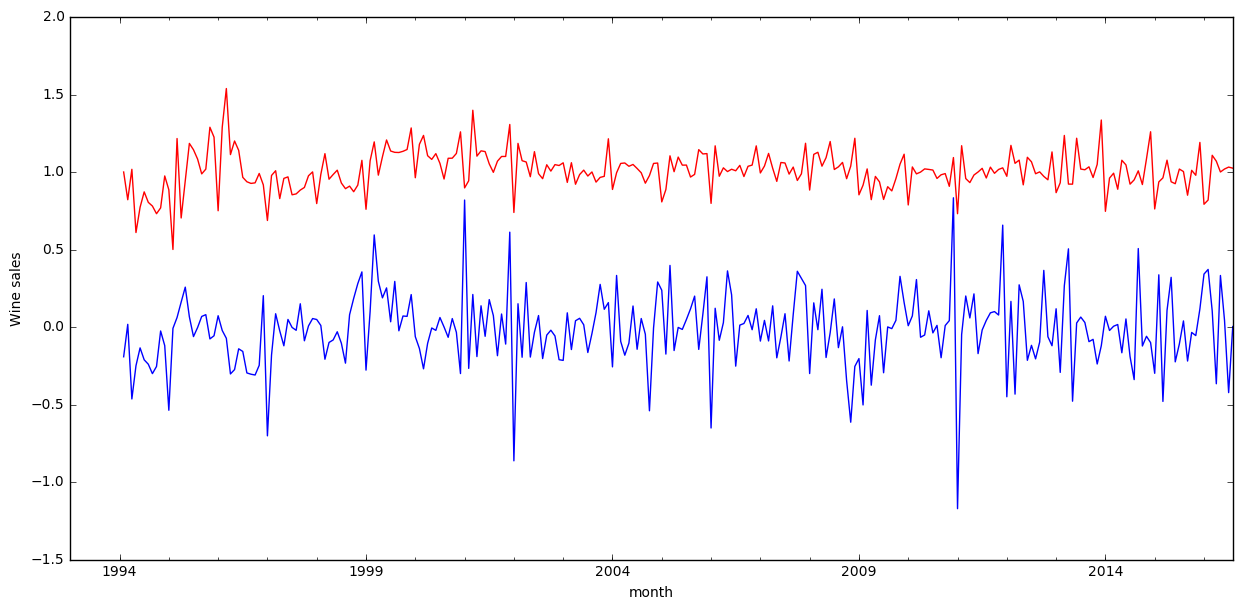

In [37]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
    
salary_data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
sal_box_diff13.plot()
salary_data.model.plot(color='r')
plt.ylabel('Wine sales')
pylab.show()